# Visualization

In [1]:
import pandas  as pd
import numpy   as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

We'll begin by loading the data and cleaning it up.

In [2]:
border_crossing = pd.read_csv('../data/Border_Crossing_Entry_Data.csv')
border_crossing.head()

,Port Name,State,Port Code,Border,Date,Measure,Value,Location
0,Calexico East,California,2507,US-Mexico Border,03/01/2019 12:00:00 AM,Trucks,34447,POINT (-115.48433000000001 32.67524)
1,Van Buren,Maine,108,US-Canada Border,03/01/2019 12:00:00 AM,Rail Containers Full,428,POINT (-67.94271 47.16207)
2,Otay Mesa,California,2506,US-Mexico Border,03/01/2019 12:00:00 AM,Trucks,81217,POINT (-117.05333 32.57333)
3,Nogales,Arizona,2604,US-Mexico Border,03/01/2019 12:00:00 AM,Trains,62,POINT (-110.93361 31.340279999999996)
4,Trout River,New York,715,US-Canada Border,03/01/2019 12:00:00 AM,Personal Vehicle Passengers,16377,POINT (-73.44253 44.990010000000005)


The date needs to be parsed from a string. Despite including day and time, these are always 1 and 12AM respectively, so we don't bother parsing these. Thus, we are left with month and year. We sort the data chronologically.

In [3]:
def parse_date(s): 
    date, *_ = s.strip().split()
    [month, day, year] = list(map(int, date.split(sep='/')))
    return datetime.date(year, month, day)

border_crossing['Date'] = border_crossing['Date'].apply(parse_date)
border_crossing = border_crossing.sort_values(by='Date')
border_crossing.head()

,Port Name,State,Port Code,Border,Date,Measure,Value,Location
346732,Presidio,Texas,2403,US-Mexico Border,1996-01-01,Trucks,347,POINT (-104.39000000000001 29.56)
345903,Whitlash,Montana,3321,US-Canada Border,1996-01-01,Truck Containers Full,0,POINT (-111.26000000000002 49)
345904,Jackman,Maine,104,US-Canada Border,1996-01-01,Truck Containers Full,2103,POINT (-70.4 45.81)
345905,Hidalgo,Texas,2305,US-Mexico Border,1996-01-01,Truck Containers Full,9794,POINT (-98.27 26.1)
345906,Boundary,Washington,3015,US-Canada Border,1996-01-01,Pedestrians,0,POINT (-117.62999999999998 49)


Similarily, the location data, representing longitude and latitude, must be parsed from a string.

In [4]:
def parse_loc(s):
    long, lat = list(map(float, s.strip()[7:-1].split()))
    return (long,lat)
    
border_crossing['Location'] = border_crossing['Location'].apply(parse_loc)
border_crossing.head()

,Port Name,State,Port Code,Border,Date,Measure,Value,Location
346732,Presidio,Texas,2403,US-Mexico Border,1996-01-01,Trucks,347,"(-104.39000000000001, 29.56)"
345903,Whitlash,Montana,3321,US-Canada Border,1996-01-01,Truck Containers Full,0,"(-111.26000000000002, 49.0)"
345904,Jackman,Maine,104,US-Canada Border,1996-01-01,Truck Containers Full,2103,"(-70.4, 45.81)"
345905,Hidalgo,Texas,2305,US-Mexico Border,1996-01-01,Truck Containers Full,9794,"(-98.27, 26.1)"
345906,Boundary,Washington,3015,US-Canada Border,1996-01-01,Pedestrians,0,"(-117.62999999999998, 49.0)"


Finally, we designate the categorical columns for more efficient representation.

In [5]:
for col in ['Port Name', 'State', 'Port Code', 'Border', 'Measure']:
    border_crossing[col] = border_crossing[col].astype('category')

Here, we start to separate our data for various visualizations.

In [6]:
totals     = border_crossing.groupby('Date').sum()
by_ports   = border_crossing.groupby(['Date', 'Port Name']).sum()
by_measure = border_crossing.groupby(['Date', 'Measure']).sum()
by_both    = border_crossing.groupby(['Date', 'Port Name', 'Measure']).sum()

# Flatten Multiindex/hieararchical structures
totals     = pd.DataFrame(totals.to_records())
by_ports   = pd.DataFrame(by_ports.to_records())
by_measure = pd.DataFrame(by_measure.to_records())
by_both    = pd.DataFrame(by_both.to_records())

To start off, let's view the total traffic over time.

/home/grant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


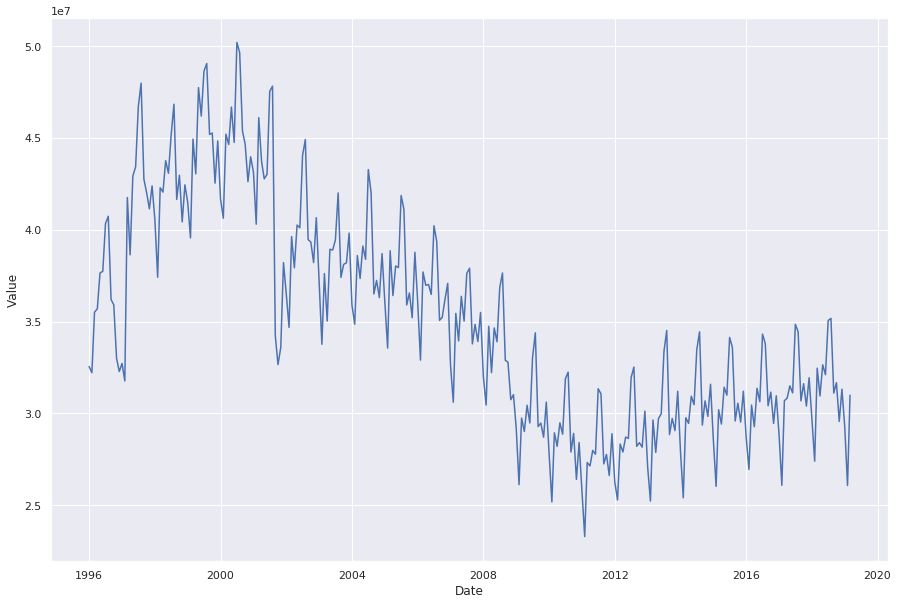

In [7]:
sns.set(rc={'figure.figsize':(15,10)})
sns.lineplot(x='Date', y='Value', data=totals)

This is a great depiction of the overarching trend. Clearly there is a there is a regular cycle of spikes affecting an underlying curve. However, at this scope, it is difficult to see the period of these fluctuations. Perhaps they correspond to specifics months. Let's zoom in on an arbitrary couple of years to investigate further.

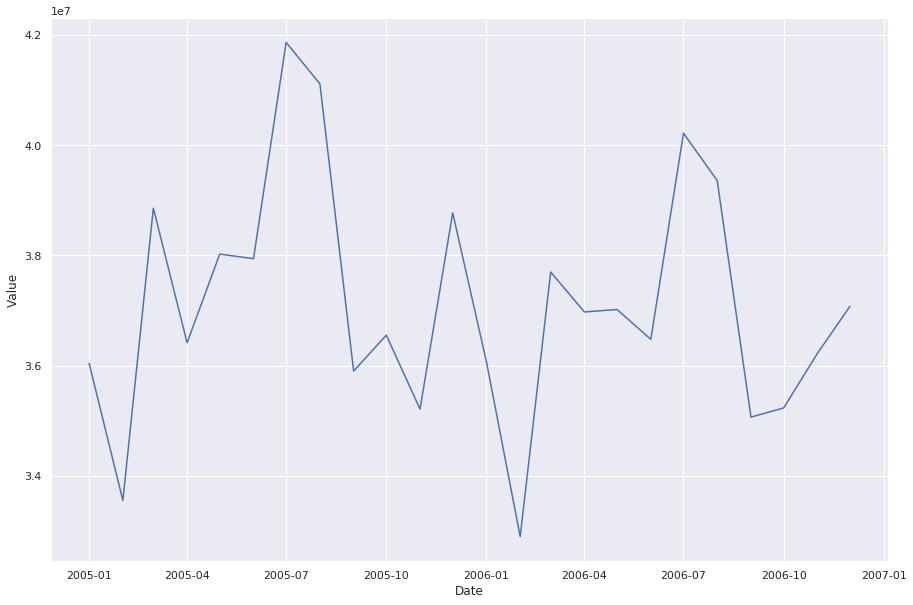

In [8]:
totals_05_06 = totals[totals['Date'].apply(lambda d: d.year == 2005 or d.year == 2006)]
sns.lineplot(x='Date', y='Value', data=totals_05_06)

This is neat, but I think we can do even better. Let's layer all the years on top eachother.

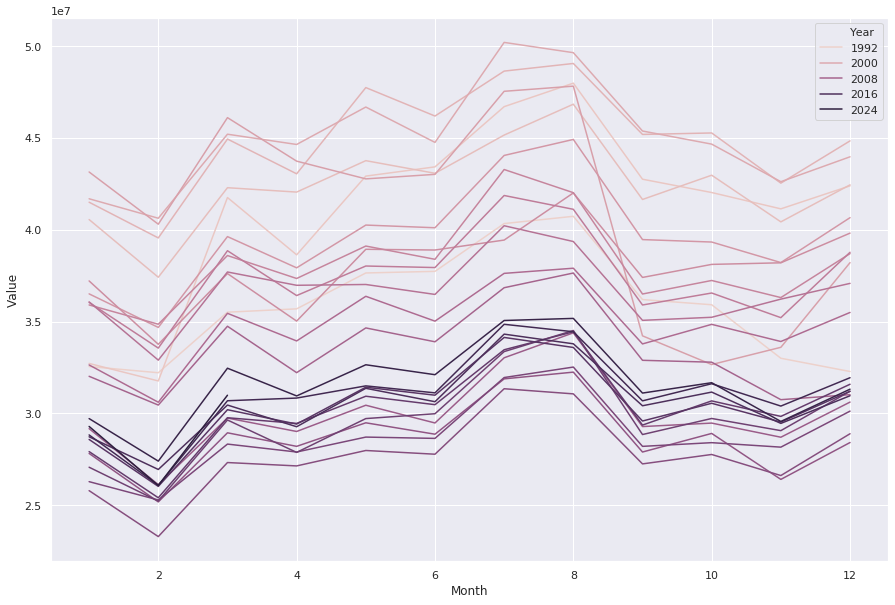

In [9]:
layered = totals.copy()
layered['Year'] = layered['Date'].apply(lambda d: d.year)
layered['Month'] = layered['Date'].apply(lambda d: d.month)

sns.lineplot(x='Month', y='Value', hue='Year', data=layered)

This certainly affirms our suspicion that the regular spikes are tied to month. A common pattern is evident across the many years, although the reasons for these predictable fluctuations are a mystery.

Now let's take a look at the overall volume of traffic, separted by port.

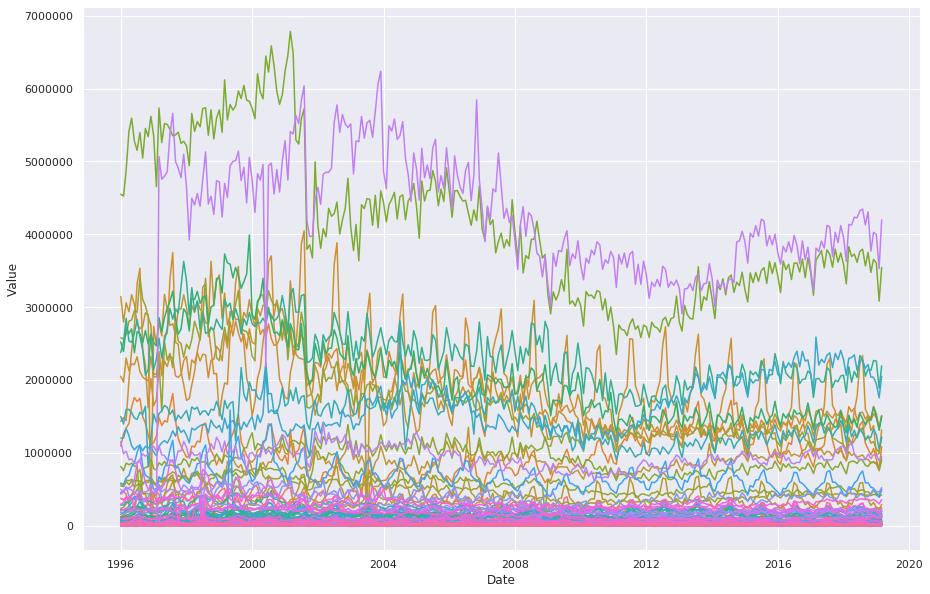

In [10]:
sns.lineplot(x='Date', y='Value', hue='Port Name', data=by_ports, legend=False)

There high number of ports makes this graph difficult to disern. In addition, there is concern that the trends of some ports aren't visible, due to their relatively low values.

This concern is even more present as we look at the data with respect to various modes of transportation.

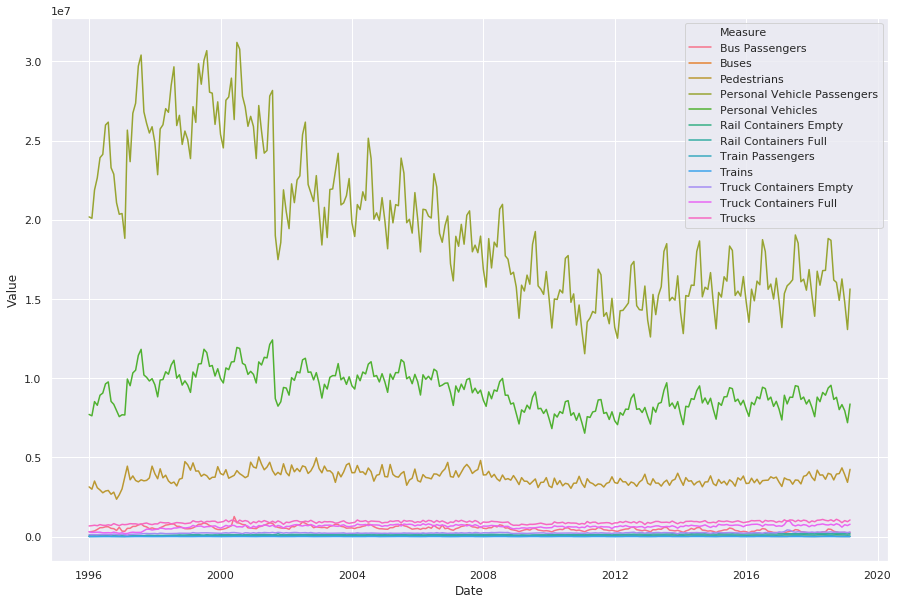

In [11]:
sns.lineplot(x='Date', y='Value', hue='Measure', data=by_measure)

For some modes of transport, the values are measured in the millions. For others, in the thousands. This may mean our models will have to deal with them separately. Let's try and visualize all the transports at the bottom separately so that their scales are more sensible.

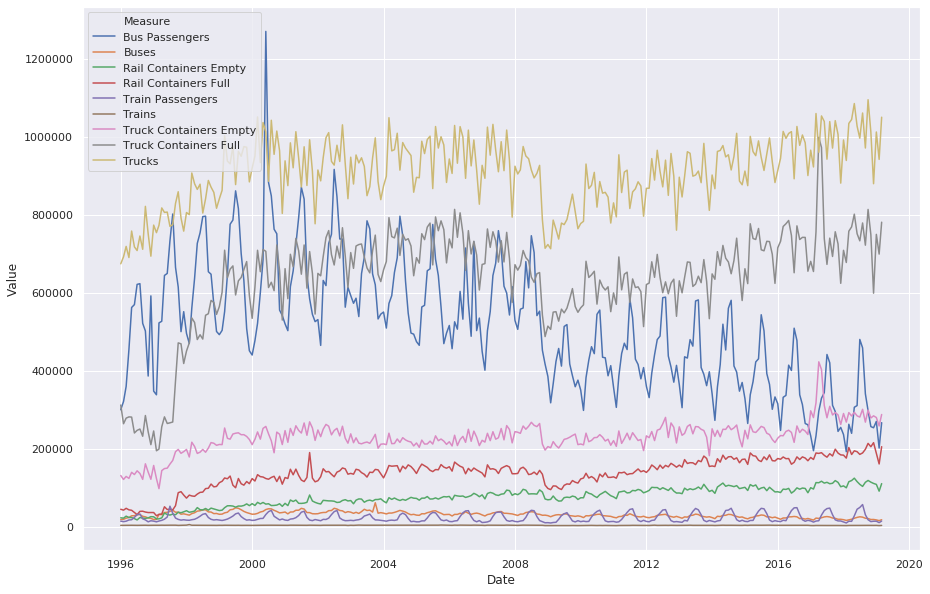

In [14]:
by_measure_lows = by_measure[by_measure['Measure'].apply(lambda m: not(m == 'Personal Vehicle Passengers' or m == 'Personal Vehicles' or m == 'Pedestrians'))]
sns.lineplot(x='Date', y='Value', hue='Measure', data=by_measure_lows)

Finally, let's look at the singular mode of transport "Trains", which is still being flattened by the y-scaling.

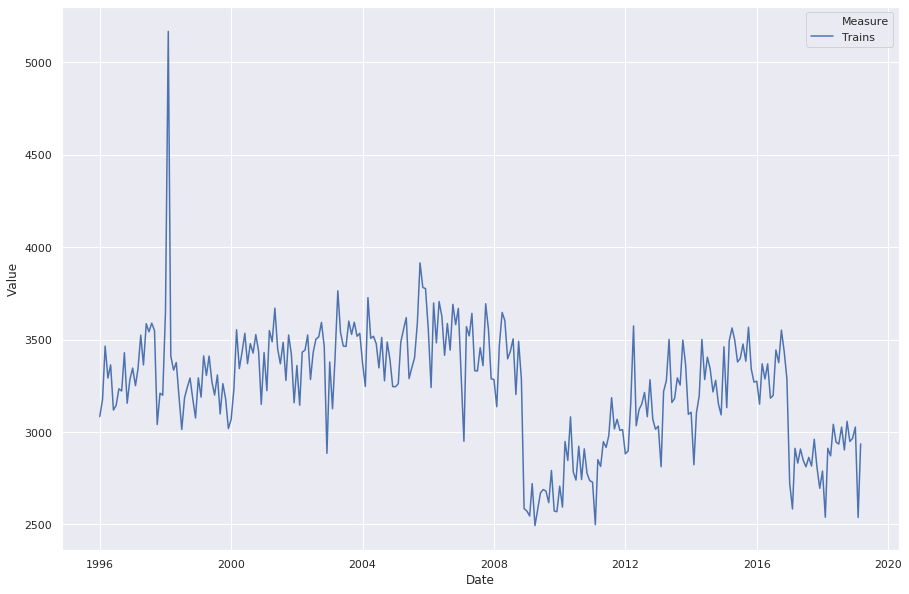

In [20]:
just_trains = by_measure[by_measure['Measure'] == 'Trains']
sns.lineplot(x='Date', y='Value', hue='Measure', data=just_trains)

This appeared perfectly flat in each of the other graphs, but we can now see some very interesting properties. For instance, we see an outlier, an incredible spike, around 1998, and a drastic drop a little before 2009, which is also noticeable in a couple of other modes of transport.

Now, Let's try to view by port and by transport simultaneously.

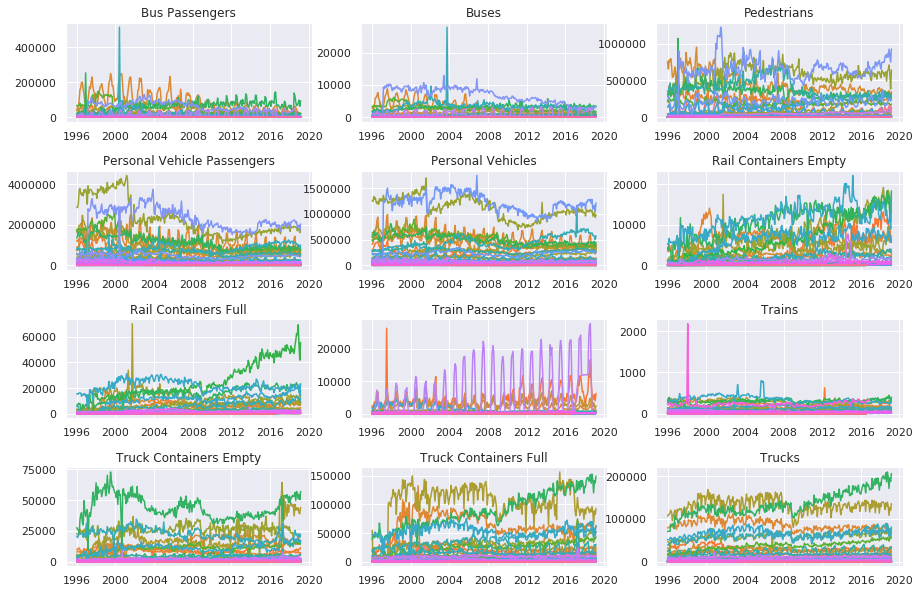

In [21]:
measures = list(by_both['Measure'].unique())

fig, ax = plt.subplots(4,3)
fig.subplots_adjust(hspace=0.5)
for idx, measure in enumerate(measures):
    data = by_both[by_both['Measure'] == measure].dropna()
    plot = sns.lineplot(x='Date', y='Value', hue='Port Name', data=data, legend=False, ax=ax.flatten()[idx])
    plot.set(title=measure, ylabel='', xlabel='')
plt.show()

Trying to visualize so much at turns out to be largely unproductive. Most of the graphs are too busy to reveal much information. However, there are some interesting properties we can pick out. For instance, we can see some clear outliers in some of the data sets, indicating anomaly detection would be helpful. We also see that "Train pasengers is incredibly cyclical with respect to the year.

Before moving on, let's try this again, but this time assembling the rows carefully such that we use a common y-axis.

(TODO)

In [ ]:
def fst(p):
    (f, _) = p
    return f
def snd(p):
    (_, s) = p
    return s

border_crossing['Longitude'] = border_crossing['Location'].apply(fst)
border_crossing['Latitude']  = border_crossing['Location'].apply(snd)
border_crossing

In [ ]:
# by_loc = border_crossing.groupby(['Date', 'Longitude', 'Latitude']).sum()
by_loc = border_crossing.groupby(['Longitude', 'Latitude']).sum()
by_loc = pd.DataFrame(by_loc.to_records())
by_loc

In [ ]:
sns.scatterplot(x='Longitude', y='Latitude', size='Value', data=by_loc)

In [ ]:
by_loc = border_crossing.groupby(['Measure', 'Longitude', 'Latitude']).sum()
by_loc = pd.DataFrame(by_loc.to_records()).dropna()

In [ ]:
sns.scatterplot(x='Longitude', y='Latitude', size='Value', hue='Measure', data=border_crossing)

In [ ]:
import plotly.express as px
# import plotly.graph_objects as go

In [ ]:
by_loc = border_crossing.groupby(['Date', 'Longitude', 'Latitude']).sum()
by_loc = pd.DataFrame(by_loc.to_records()).dropna()

by_loc['Location'] = list(zip(by_loc['Longitude'], by_loc['Latitude']))
del by_loc['Longitude']
del by_loc['Latitude']
by_loc

In [ ]:
# px.scatter_geo(border_crossing, locations='Location', color='Measure', size='Value', animation_frame='Date', projection='usa')
px.scatter_geo(by_loc, locations='Location', size='Value', animation_frame='Date', projection='usa')